In [1]:
!kaggle datasets download -d umairshahpirzada/birds-20-species-image-classification
!unzip birds-20-species-image-classification.zip

Dataset URL: https://www.kaggle.com/datasets/umairshahpirzada/birds-20-species-image-classification
License(s): unknown
 97% 67.0M/69.3M [00:04<00:00, 21.3MB/s]
100% 69.3M/69.3M [00:04<00:00, 17.4MB/s]
Archive:  birds-20-species-image-classification.zip
  inflating: images to predict/1.jpg  
  inflating: images to predict/2.jpg  
  inflating: images to predict/3.jpg  
  inflating: images to predict/4.jpg  
  inflating: images to predict/5.jpg  
  inflating: images to predict/6.jpg  
  inflating: test/ABBOTTS BABBLER/1.jpg  
  inflating: test/ABBOTTS BABBLER/2.jpg  
  inflating: test/ABBOTTS BABBLER/3.jpg  
  inflating: test/ABBOTTS BABBLER/4.jpg  
  inflating: test/ABBOTTS BABBLER/5.jpg  
  inflating: test/ABBOTTS BOOBY/1.jpg  
  inflating: test/ABBOTTS BOOBY/2.jpg  
  inflating: test/ABBOTTS BOOBY/3.jpg  
  inflating: test/ABBOTTS BOOBY/4.jpg  
  inflating: test/ABBOTTS BOOBY/5.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/1.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/2.jp

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import shutil
from google.colab import files
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.datasets import ImageFolder
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_transform = transforms.Compose([
    transforms.RandomGrayscale(p=0.5),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation within 30 degrees
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),  #  brightness, contrast, saturation
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.ToTensor()
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(root='/content/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/valid',transform=val_transforms)
test_dataset = datasets.ImageFolder(root='/content/test',transform=test_transforms)


print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

3208
100
100


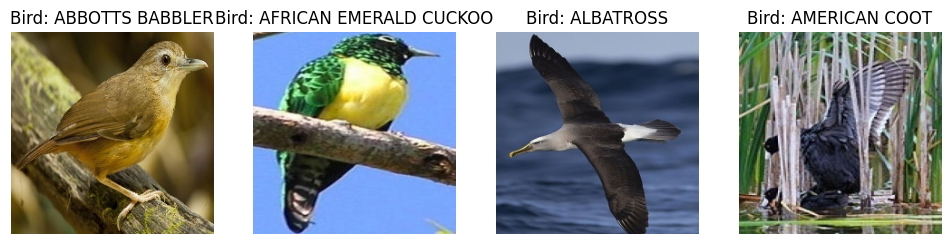

In [3]:

dataset_path = '/content/train'
class_names = ["ABBOTTS BABBLER","AFRICAN EMERALD CUCKOO","ALBATROSS","AMERICAN COOT"]
plt.figure(figsize=(12, 6))
for i, bird_class in enumerate(class_names):
    class_images = os.listdir(os.path.join(dataset_path, bird_class))
    if class_images:
        image_name = class_images[0]
        image_path = os.path.join(dataset_path, bird_class, image_name)
        image = Image.open(image_path)
        plt.subplot(1, len(class_names), i+1)
        plt.imshow(image)
        plt.title(f'Bird: {bird_class}')
        plt.axis('off')

plt.show()

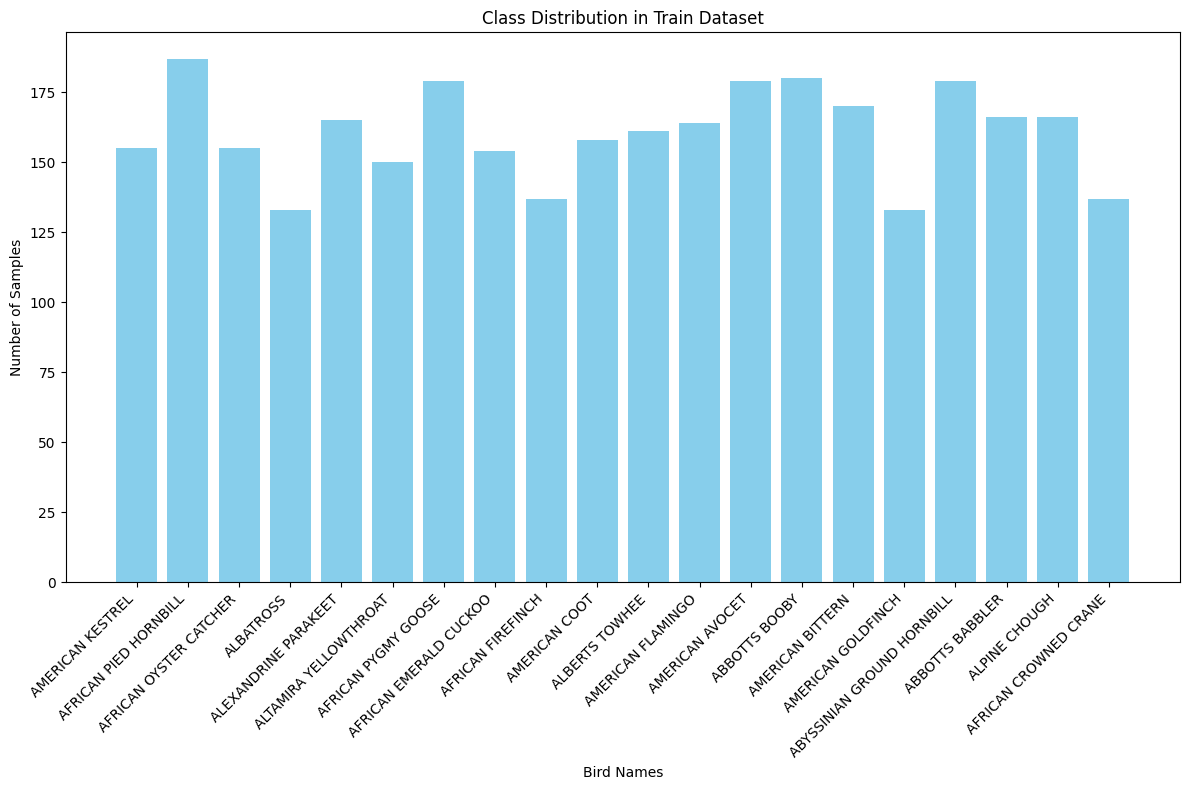

In [4]:
class_names = os.listdir('/content/train')

# Count the number of samples in each class
class_counts = []
for class_name in class_names:
    class_path = os.path.join('/content/train', class_name)
    num_samples = len(os.listdir(class_path))
    class_counts.append(num_samples)

# Plot the bar graph
plt.figure(figsize=(12, 8))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Bird Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Train Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.tight_layout()
plt.show()


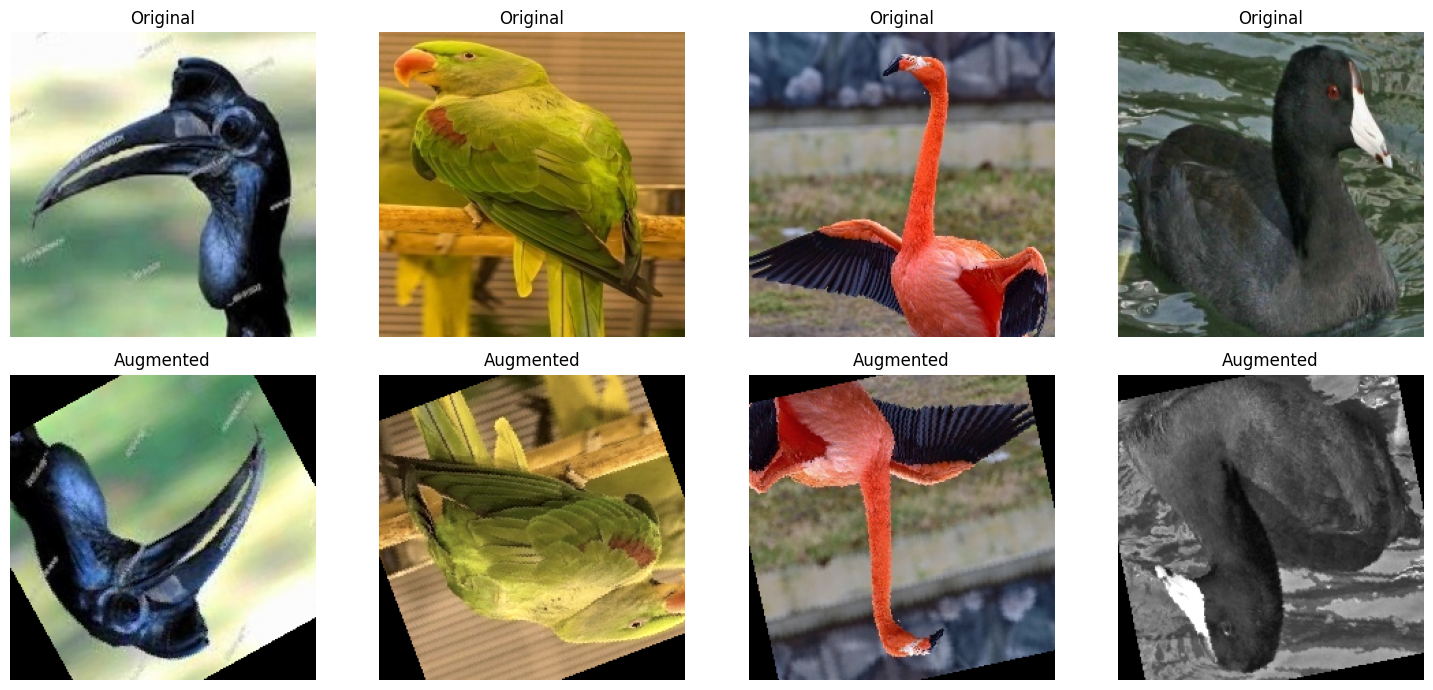

In [5]:


# Define the original transform and augmentation transform
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomHorizontalFlip(p=1),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation within 30 degrees
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),  # Random color jitter
    transforms.RandomVerticalFlip(p=1),  # Random vertical flip
    transforms.ToTensor()
])


dataset = ImageFolder(root='/content/train', transform=original_transform)
indices = torch.randint(len(dataset), (4,))
selected_images = [dataset[i][0] for i in indices]
selected_pil_images = [transforms.ToPILImage()(img) for img in selected_images]
augmented_images = [augmentation_transform(img) for img in selected_pil_images]

def show_images_side_by_side(original, augmented):
    fig, axes = plt.subplots(2, 4, figsize=(15, 7))
    for i in range(4):
        # Original images
        img_original = original[i].permute(1, 2, 0)
        img_original = (img_original - img_original.min()) / (img_original.max() - img_original.min())
        axes[0, i].imshow(img_original)
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Augmented images
        img_augmented = augmented[i].permute(1, 2, 0)
        img_augmented = (img_augmented - img_augmented.min()) / (img_augmented.max() - img_augmented.min())
        axes[1, i].imshow(img_augmented)
        axes[1, i].axis('off')
        axes[1, i].set_title("Augmented")

    plt.tight_layout()
    plt.show()

# Display the images
show_images_side_by_side(selected_images, augmented_images)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 101MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]
100%|██████████| 51/51 [00:29<00:00,  1.71it/s]


Epoch 1/10, Train Loss: 2.9276, Validation Loss: 2.6362, Accuracy: 21.00%


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Epoch 2/10, Train Loss: 2.6714, Validation Loss: 2.3356, Accuracy: 25.00%


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Epoch 3/10, Train Loss: 2.5052, Validation Loss: 2.1805, Accuracy: 36.00%


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Epoch 4/10, Train Loss: 2.3652, Validation Loss: 1.9981, Accuracy: 41.00%


100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Epoch 5/10, Train Loss: 2.2094, Validation Loss: 1.7325, Accuracy: 47.00%


100%|██████████| 51/51 [00:29<00:00,  1.75it/s]


Epoch 6/10, Train Loss: 2.1072, Validation Loss: 1.6678, Accuracy: 46.00%


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Epoch 7/10, Train Loss: 2.0747, Validation Loss: 1.4702, Accuracy: 56.00%


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Epoch 8/10, Train Loss: 1.9679, Validation Loss: 1.3915, Accuracy: 62.00%


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]


Epoch 9/10, Train Loss: 1.9754, Validation Loss: 1.3168, Accuracy: 58.00%


100%|██████████| 51/51 [00:31<00:00,  1.59it/s]


Epoch 10/10, Train Loss: 1.8796, Validation Loss: 1.4461, Accuracy: 56.00%


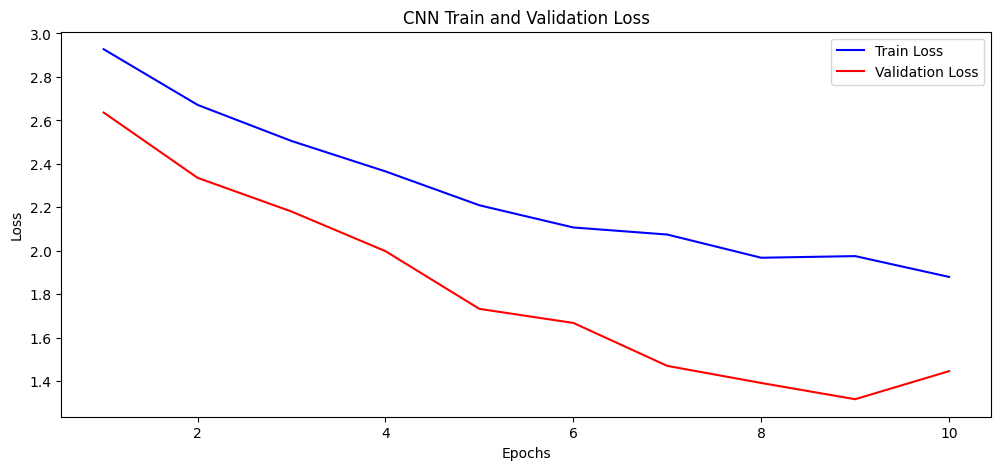

Test Accuracy: 53.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.40      0.57         5
           2       0.36      0.80      0.50         5
           3       1.00      0.40      0.57         5
           4       0.50      0.60      0.55         5
           5       0.45      1.00      0.62         5
           6       1.00      0.20      0.33         5
           7       0.43      0.60      0.50         5
           8       1.00      0.20      0.33         5
           9       1.00      0.60      0.75         5
          10       1.00      0.20      0.33         5
          11       1.00      0.80      0.89         5
          12       0.50      0.40      0.44         5
          13       0.57      0.80      0.67         5
          14       0.60      0.60      0.60         5
          15       0.28      1.00      0.43         5
          16       1.00      0.80   

In [7]:


# CNN Model definition
class CNN(nn.Module):
    def __init__(self, num_classes=20):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load pre-trained models
resnet50 = torchvision.models.resnet50(pretrained=True)
densenet121 = torchvision.models.densenet121(pretrained=True)
vgg16 = torchvision.models.vgg16(pretrained=True)

num_classes = 20
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, num_classes)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Initialize models
resnet50 = resnet50.to(device)
densenet121 = densenet121.to(device)
vgg16 = vgg16.to(device)
cnn_model = CNN(num_classes=num_classes).to(device)

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam(resnet50.parameters(), lr=0.0001)
optimizer_densenet121 = optim.Adam(densenet121.parameters(), lr=0.0001)
optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=0.0001)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0001)

# Helper function to plot metrics
def plot_metrics(train_losses, val_losses, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title(f'{model_name} Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation step
        val_loss = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    plot_metrics(train_losses, val_losses, val_accuracies, model.__class__.__name__)

    return model, val_accuracies[-1]  # Return the trained model and last validation accuracy

# Function to test the model and generate the classification report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

    return 100 * correct / total  # Return the test accuracy

accuracies_df = pd.DataFrame(columns=["Model", "Test Accuracy"])
accuracies_list = []

# Train and test CNN
model_cnn, accuracy_cnn = train_model(cnn_model, train_loader, val_loader, criterion, optimizer_cnn, num_epochs=10)
test_accuracy_cnn = test_model(model_cnn, test_loader)
accuracies_list.append({"Model": "CNN", "Test Accuracy": test_accuracy_cnn})

100%|██████████| 51/51 [01:01<00:00,  1.21s/it]


Epoch 1/3, Train Loss: 2.6404, Validation Loss: 1.5659, Accuracy: 48.00%


100%|██████████| 51/51 [01:01<00:00,  1.20s/it]


Epoch 2/3, Train Loss: 1.5831, Validation Loss: 0.6951, Accuracy: 75.00%


100%|██████████| 51/51 [01:01<00:00,  1.21s/it]


Epoch 3/3, Train Loss: 0.9005, Validation Loss: 0.4230, Accuracy: 87.00%


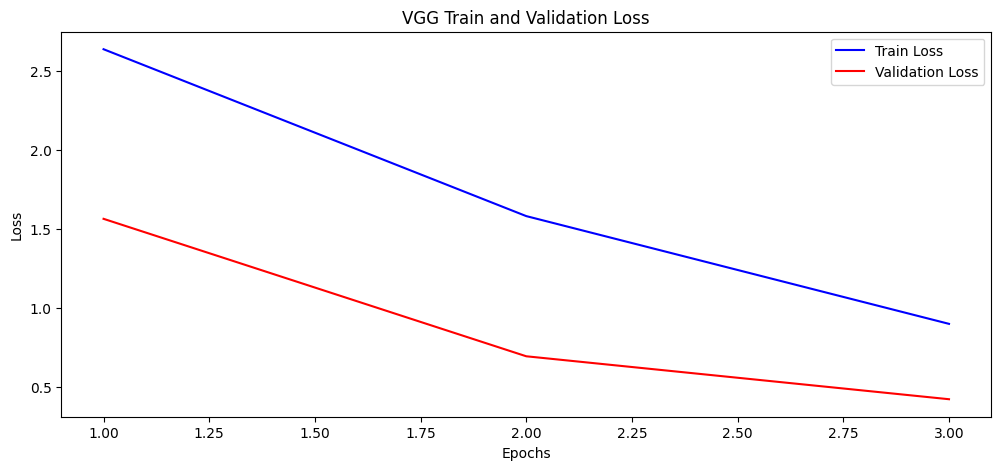

Test Accuracy: 77.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       1.00      0.20      0.33         5
           2       0.56      1.00      0.71         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.38      1.00      0.56         5
           6       0.71      1.00      0.83         5
           7       1.00      0.40      0.57         5
           8       1.00      1.00      1.00         5
           9       0.56      1.00      0.71         5
          10       1.00      0.40      0.57         5
          11       0.83      1.00      0.91         5
          12       1.00      0.60      0.75         5
          13       1.00      0.40      0.57         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89         5
          16       1.00      0.80   

In [8]:
# Train and test VGG16
model_vgg16, accuracy_vgg16 = train_model(vgg16, train_loader, val_loader, criterion, optimizer_vgg16, num_epochs=3)
test_accuracy_vgg16 = test_model(model_vgg16, test_loader)
accuracies_list.append({"Model": "VGG16", "Test Accuracy": test_accuracy_vgg16})

100%|██████████| 51/51 [00:47<00:00,  1.07it/s]


Epoch 1/3, Train Loss: 2.0794, Validation Loss: 0.8048, Accuracy: 90.00%


100%|██████████| 51/51 [00:47<00:00,  1.06it/s]


Epoch 2/3, Train Loss: 0.8325, Validation Loss: 0.3863, Accuracy: 93.00%


100%|██████████| 51/51 [00:48<00:00,  1.06it/s]


Epoch 3/3, Train Loss: 0.4416, Validation Loss: 0.2145, Accuracy: 97.00%


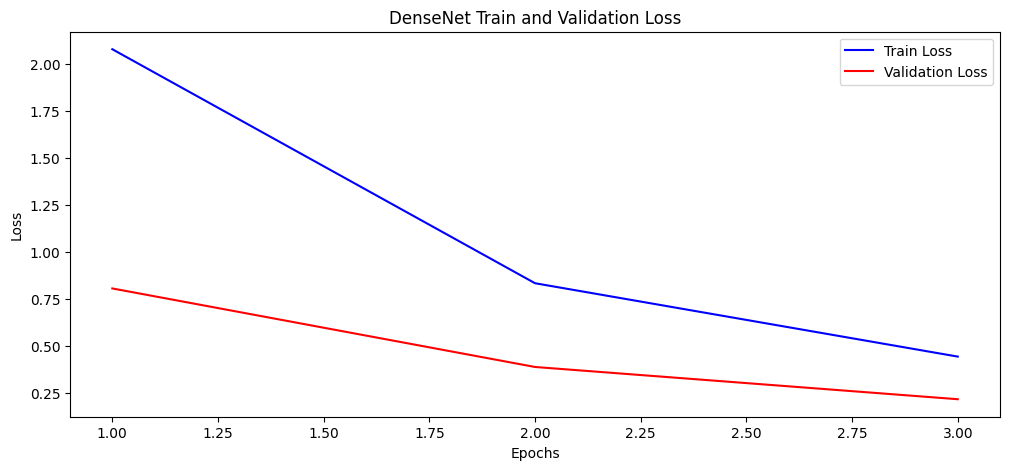

Test Accuracy: 95.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.71      1.00      0.83         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      0.40      0.57         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00   

In [9]:
# Train and test DenseNet121
model_densenet121, accuracy_densenet121 = train_model(densenet121, train_loader, val_loader, criterion, optimizer_densenet121, num_epochs=3)
test_accuracy_densenet121 = test_model(model_densenet121, test_loader)
accuracies_list.append({"Model": "DenseNet121", "Test Accuracy": test_accuracy_densenet121})

100%|██████████| 51/51 [00:46<00:00,  1.09it/s]


Epoch 1/3, Train Loss: 1.5351, Validation Loss: 0.2893, Accuracy: 97.00%


100%|██████████| 51/51 [00:45<00:00,  1.11it/s]


Epoch 2/3, Train Loss: 0.3682, Validation Loss: 0.1452, Accuracy: 95.00%


100%|██████████| 51/51 [00:46<00:00,  1.10it/s]


Epoch 3/3, Train Loss: 0.2354, Validation Loss: 0.1112, Accuracy: 96.00%


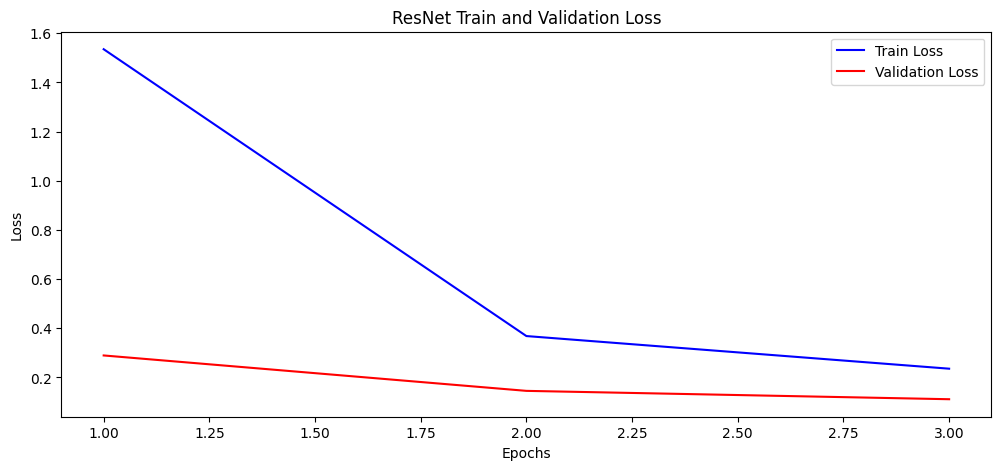

Test Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00  

In [10]:
# Train and test ResNet50
model_resnet50, accuracy_resnet50 = train_model(resnet50, train_loader, val_loader, criterion, optimizer_resnet50, num_epochs=3)
test_accuracy_resnet50 = test_model(model_resnet50, test_loader)
accuracies_list.append({"Model": "ResNet50", "Test Accuracy": test_accuracy_resnet50})


In [11]:
accuracies_df = pd.DataFrame(accuracies_list)
accuracies_df


,Model,Test Accuracy
0,CNN,53.0
1,VGG16,77.0
2,DenseNet121,95.0
3,ResNet50,100.0
